In [145]:
import glob
import os
import urllib
import numpy as np


import matplotlib.pyplot as plt
import xmltodict
import cv2

import tempfile

import torch

%matplotlib inline

In [146]:
# path = tempfile.mkdtemp()
# print(path)
img_name = '2018_MLBS_3_541000_4140000_image_crop.tif'
img_path = f'C:\\bin\python\jupyter-notebook\\remote-sensing-deepforest\images\{img_name}'
print(img_path)
# filenames = glob.glob(os.path.join(path, './NEONsample_RGB/*.tif'))
# filesn = [os.path.basename(i) for i in filenames]

C:\bin\python\jupyter-notebook\remote-sensing-deepforest\images\2018_MLBS_3_541000_4140000_image_crop.tif


In [147]:
def loadxml(imagename):
  imagename = imagename.replace('.tif','')
  fullurl = "https://raw.githubusercontent.com/weecology/NeonTreeEvaluation/master/annotations/" + imagename + ".xml"
  file = urllib.request.urlopen(fullurl)
  data = file.read()
  file.close()
  data = xmltodict.parse(data)
  return data

# allxml = [loadxml(i) for i in filesn]
xml = loadxml(img_name)
print(f"There's a total of {len(xml['annotation']['object'])} bound boxes in this image")

There's a total of 864 bound boxes in this image


In [148]:
annotations = xml['annotation']
import json
    
with open("annotations.json", "w") as outfile:
    json.dump(annotations, outfile)

In [149]:
# print(annotations)  

In [150]:
# function to extract bounding boxes
def extractbb(xml):
  bb = [f['bndbox'] for f in xml['annotation']['object']]
  return bb

bball = extractbb(xml)
with open("boundingBoxes.json", "w") as outfile:
    json.dump(bball, outfile)

In [151]:
print(type(bball[0]))
print(type(bball))
print(len(bball))

<class 'dict'>
<class 'list'>
864


In [152]:
# function to plot images
def plot_show(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    # if a.ndim == 3:
    #     if a.shape[2] == 4:
    #         a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    #     else:
    #         a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)

In [153]:
# Original Image
og_image = cv2.imread(img_path)
print(type(og_image))

<class 'numpy.ndarray'>


In [154]:
if type(og_image) != None and og_image.size != 0:
    cv2.imshow('input', og_image)
    cv2.waitKey(0)

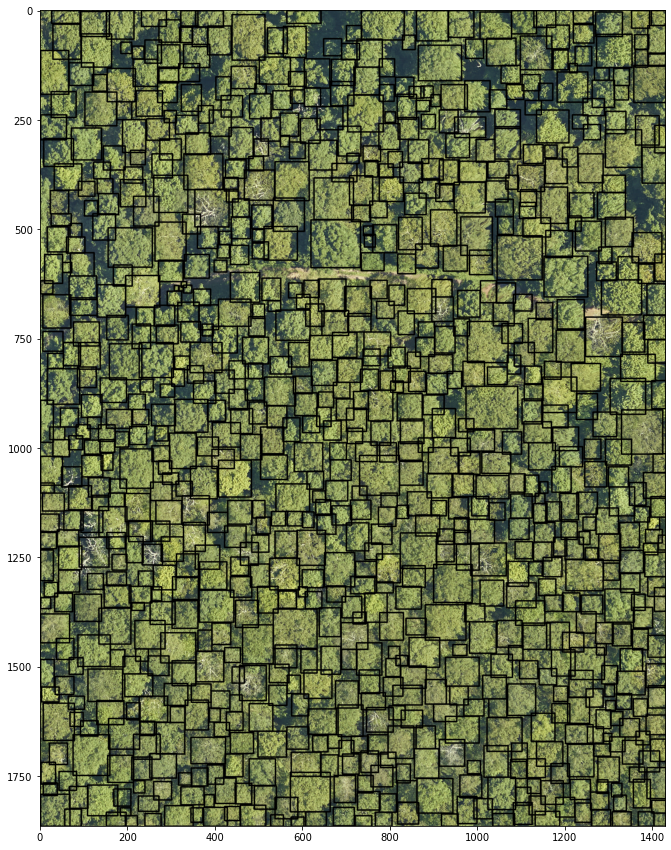

In [156]:
# Copy of Original Image with already know data set
dt_image = cv2.imread(img_path)
for row in bball:
    cv2.rectangle(dt_image, (int(row["xmin"]), int(row["ymin"])), (int(row["xmax"]), int(row["ymax"])), (0, 0, 0), thickness=2, lineType=cv2.LINE_AA)

plt.figure(figsize=(15,15))
plot_show(np.flip(dt_image,2))
plt.show()

## Load *DeepForest* pretrained model

Now we're going to load and use a pretrained model from the `deepforest` package.

In [157]:
from deepforest import main

In [158]:
# load deep forest model
model = main.deepforest()
model.use_release()
model.current_device = torch.device("cpu")

Reading config file: C:\Users\PROGRAMMER\AppData\Local\Programs\Python\Python310\lib\site-packages\deepforest\data\deepforest_config.yml


C:\Users\PROGRAMMER\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\PROGRAMMER\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [159]:
# Predicted images, a copy of the original image
pr_image = cv2.imread(img_path)
# Predicted bounding boxes
pr_box = model.predict_image(pr_image, return_plot=False)

C:\Users\PROGRAMMER\AppData\Local\Programs\Python\Python310\lib\site-packages\deepforest\predict.py:34: UserWarning: Image type is uint8, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')
  warnings.warn(f"Image type is {image.dtype}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')")


In [105]:
pr_box.head(5)

xmin    ymin  xmax    ymax label     score
0   3.0   659.0  57.0   716.0  Tree  0.343881
1   0.0   101.0  58.0   180.0  Tree  0.318473
2   0.0  1019.0  35.0  1090.0  Tree  0.279726
3   0.0   392.0  28.0   464.0  Tree  0.193546
4   1.0   537.0  29.0   604.0  Tree  0.191899

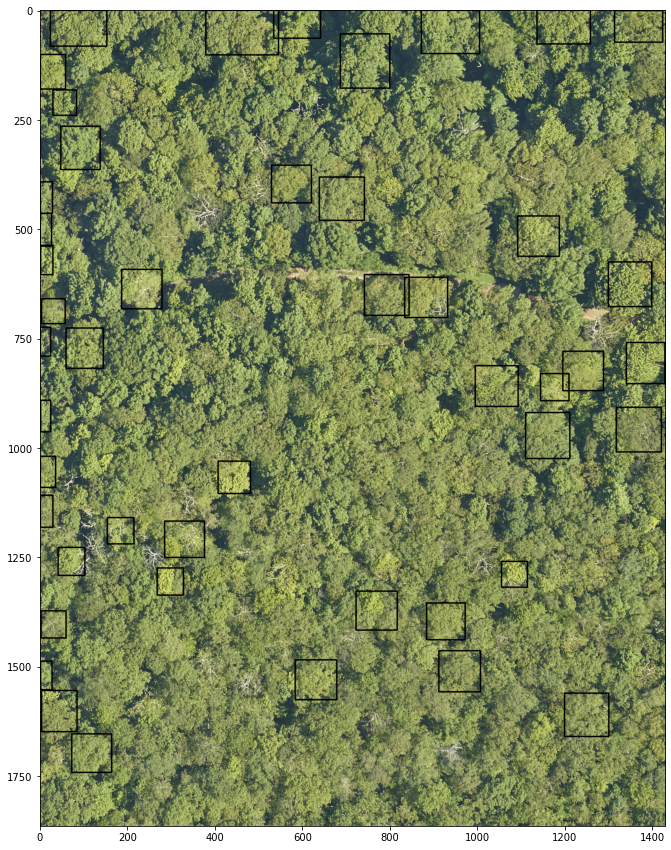

In [160]:
for index, row in pr_box.iterrows():
    cv2.rectangle(pr_image, (int(row["xmin"]), int(row["ymin"])), (int(row["xmax"]), int(row["ymax"])), (0, 0, 0), thickness=2, lineType=cv2.LINE_AA)

plt.figure(figsize=(15,15))
plot_show(np.flip(pr_image,2))
plt.show()

## Comparison full image prediction and reference labels
Let's compare the labels and predictions over the tested image.

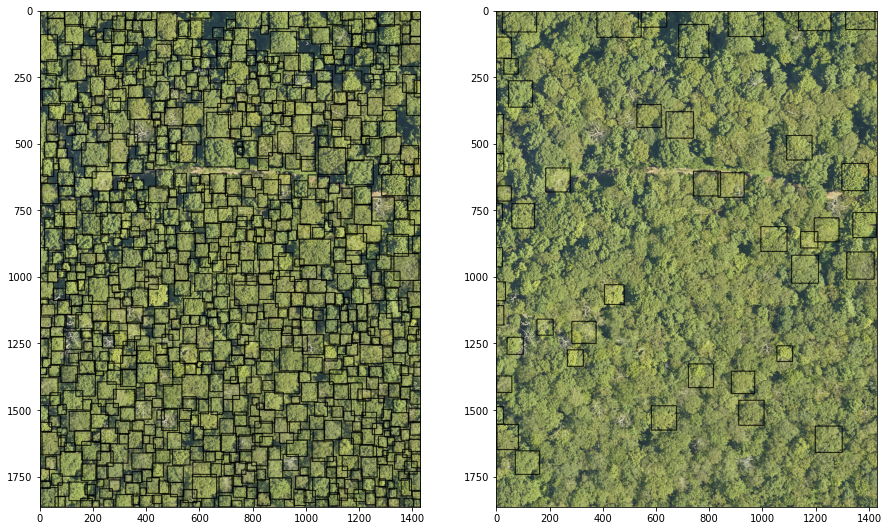

In [161]:
fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot(1, 2, 1), plot_show(np.flip(dt_image,2))
ax2 = plt.subplot(1, 2, 2), plot_show(np.flip(pr_image,2))
plt.show() # To show figure

**Interpretation:**
*   It seems the pretrained model doesn't perform well with the tested image.
*   The low performance might be explained due to the pretrained model used 10cm resolution images.

## Tile-based prediction
To optimise the predictions, the DeepForest can be run [tile-wise](https://deepforest.readthedocs.io/en/latest/better.html).

The following cells show how to define the optimal window i.e. tile size.

In [171]:
from deepforest import preprocess

image = cv2.imread(img_path)
#Create windows of 400px
windows = preprocess.compute_windows(image, patch_size=400,patch_overlap=0)
print(f'We have {len(windows)} in the image')

We have 20 in the image


In [172]:
# finding a prime number for the number of patches


C:\Users\PROGRAMMER\AppData\Local\Programs\Python\Python310\lib\site-packages\deepforest\predict.py:34: UserWarning: Image type is uint8, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')
  warnings.warn(f"Image type is {image.dtype}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')")
C:\Users\PROGRAMMER\AppData\Local\Programs\Python\Python310\lib\site-packages\deepforest\predict.py:34: UserWarning: Image type is uint8, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')
  warnings.warn(f"Image type is {image.dtype}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform ima

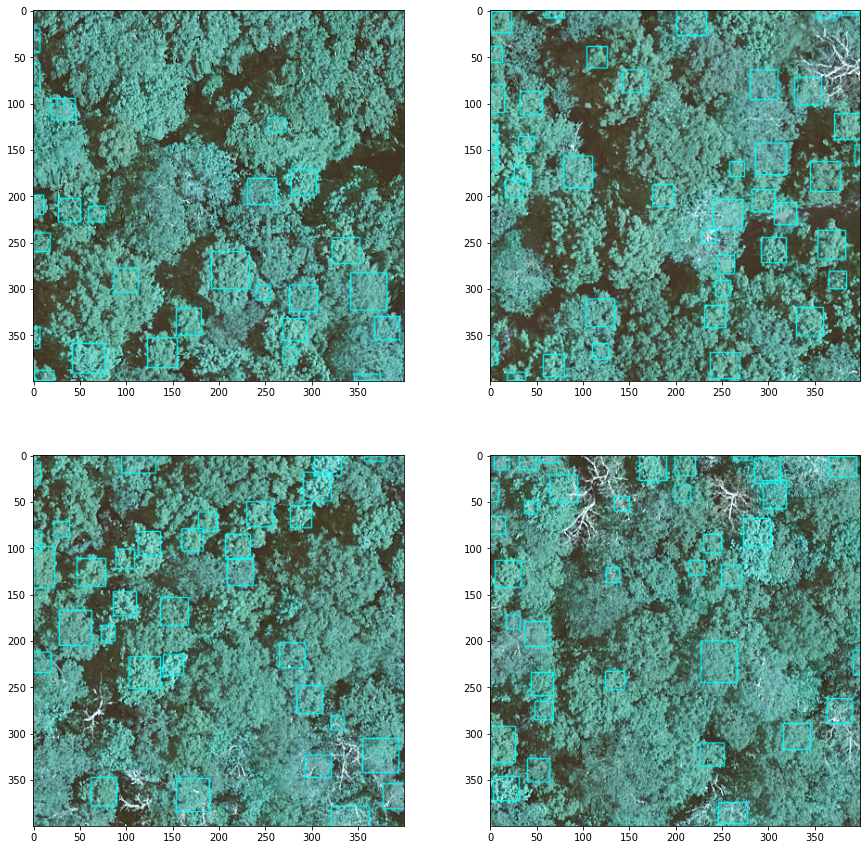

In [174]:
# #Loop through a few sample windows, crop and predict
# fig, axes, = plt.subplots(nrows=4,ncols=3, figsize=(15,15))
# axes = axes.flatten()
# total_predicted_boxes = 0
# for idx in range(0, len(windows)):
#     crop = image[windows[idx].indices()]
#     # predict in bgr channel order, color predictions in red.
#     # boxes = model.predict_image(image=np.flip(crop[...,::-1],2), return_plot = True)
#     boxes = model.predict_image(image=crop, return_plot = False)
#     total_predicted_boxes += len(boxes)
#     for index, row in boxes.iterrows():
#         cv2.rectangle(crop, (int(row["xmin"]), int(row["ymin"])), (int(row["xmax"]), int(row["ymax"])), (0, 0, 0), thickness=2, lineType=cv2.LINE_AA)
#     #but plot in rgb channel order
#     # axes[idx].imshow(boxes[...,::-1])
#     axes[idx].imshow(crop[...,::-1])

# Loop through a few sample windows, crop and predict
fig, axes, = plt.subplots(nrows=2,ncols=2, figsize=(15,15))
axes = axes.flatten()
for index2 in range(4):
    crop = image[windows[index2].indices()]
    #predict in bgr channel order, color predictions in red.
    boxes = model.predict_image(image=np.flip(crop[...,::-1],2), return_plot = True)

    #but plot in rgb channel order
    axes[index2].imshow(boxes[...,::-1])

In [ ]:
tile = model.predict_tile(image=image.values,return_plot=False,patch_overlap=0,iou_threshold=0.05,patch_size=400)

# plot predicted bbox
image_tile = image.values.copy()

for index, row in tile.iterrows():
    cv2.rectangle(image_tile, (int(row["xmin"]), int(row["ymin"])), (int(row["xmax"]), int(row["ymax"])), (0, 0, 0), thickness=10, lineType=cv2.LINE_AA)

fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot(1, 2, 1), cv2_imshow(np.flip(image2,2))
ax2 = plt.subplot(1, 2, 2), cv2_imshow(np.flip(image_tile,2))

In [170]:
print(f'We have {total_predicted_boxes} predicted boxes')

We have 298 predicted boxes
